# CSE527 Homework 5 - 1
**Due date: 11:59 pm EST on Dec. 1, 2022 (Thu.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

## Enable Colab GPU Acceleration
---
Navigation menu: **Runtime->Change runtime type->Hardware accelerator->GPU**

## Local Machine Prerequisites
---
Since we are using Google Colab, all the code is run on the server environment where lots of libraries or packages have already been installed. In case of missing 
 libraries or if you want to install them in your local machine, below are the links for installation.
* **Install Python 3.6.9**: https://www.python.org/downloads/ or use Anaconda (a Python distribution) at https://docs.continuum.io/anaconda/install/. Below are some materials and tutorials which you may find useful for learning Python if you are new to Python.
  - https://docs.python.org/3.6/tutorial/index.html
  - https://www.learnpython.org/
  - https://docs.opencv.org/4.1.2/d6/d00/tutorial_py_root.html
  - http://www.scipy-lectures.org/advanced/image_processing/index.html


* **Install Python packages**: install Python packages: `numpy`, `matplotlib`, `opencv-python` using pip, for example:
```
pip install numpy matplotlib opencv-python
``` 
	Note that when using “pip install”, make sure that the version you are using is python3. Below are some commands to check which python version it uses in you machine. You can pick one to execute:
  
```
    pip show pip
    pip --version
    pip -V
```

In case of the wrong version, use `pip3` for python3 explictly.

* **Install Jupyter Notebook**: follow the instructions at http://jupyter.org/install.html to install Jupyter Notebook and familiarize yourself  with it. *After you have installed Python and Jupyter Notebook, please open this notebook file with your Jupyter Notebook and do your homework there.*


## Description
---
In this homework, we will implement an image-to-image translation method, based on
[pix2pix](https://phillipi.github.io/pix2pix/). To be more specific,  we'll built from scratch a GAN which can translate abstract labels into facade images. 

Before we start, please read the [pix2pix paper](https://arxiv.org/pdf/1611.07004.pdf) first and understand how pix2pix works.

There are 6 parts + 1 bonus part in this homework with a total of 110 points including 10 bonus points. Be sure to read **Submission Guidelines** below. They are important.

**Do not upload** the data subfolder or trained models before submitting on blackboard due to the size limit.


## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Replace '------' with the path such that "Surname_Givenname_SBUID_hw*" is your working directory
%cd '/content/gdrive/MyDrive/ICV/Assignment 5/Dhami_Jainam_115060058_hw5'

/content/gdrive/MyDrive/ICV/Assignment 5/Dhami_Jainam_115060058_hw5


### Part 1 Load dataset
---

We'll train a model to generate pictures of facades from label maps, using the [CMP Facade
Database](http://cmp.felk.cvut.cz/~tylecr1/facade/) . This dataset contains 606 rectified images of facades from various sources, which have been manually annotated.

**{10 points}** For the training process, we will use a batch size equal to `1`, as in the original paper. During testing, we will process `4` images in a single batch, so that we can visualize
several results at once.

Load the training set and test set under the folder `./facades`. Normalize the images to $[-1, 1]$. For each set, return a batch list. Show one image from the training set and its label side by side in a `1x2` grid.

In [ ]:
# # download the dataset
! chmod +x ./download_dataset.sh
! ./download_dataset.sh
!tar -xzvf "./facades.tar.gz" -C "/content/gdrive/MyDrive/ICV/Assignment 5/Dhami_Jainam_115060058_hw5" 

for details.

--2022-12-04 23:21:55--  http://efrosgans.eecs.berkeley.edu/pix2pix/datasets/facades.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 30168306 (29M) [application/x-gzip]
Saving to: ‘facades.tar.gz’

facades.tar.gz      100%[===================>]  28.77M   496KB/s    in 72s     

2022-12-04 23:23:07 (409 KB/s) - ‘facades.tar.gz’ saved [30168306/30168306]

facades/
facades/test/
facades/test/27.jpg
facades/test/5.jpg
facades/test/72.jpg
facades/test/1.jpg
facades/test/10.jpg
facades/test/100.jpg
facades/test/101.jpg
facades/test/102.jpg
facades/test/103.jpg
facades/test/104.jpg
facades/test/105.jpg
facades/test/106.jpg
facades/test/11.jpg
facades/test/12.jpg
facades/test/13.jpg
facades/test/14.jpg
facades/test/15.jpg
facades/test/16.jpg
facades/test/17.jpg
facades/test/18.j

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import imageio
from torchvision import transforms
from PIL import Image

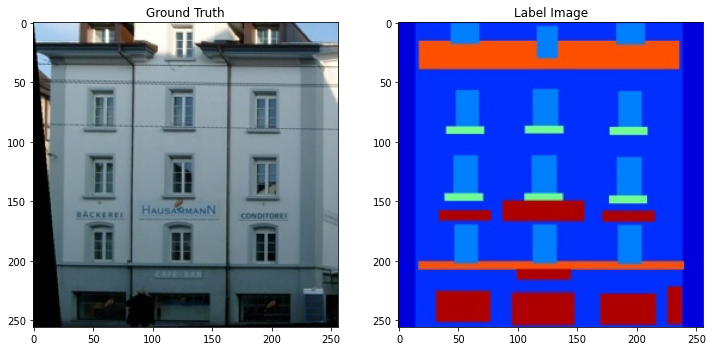

In [ ]:
def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

def load_dataset(path, shuffle=False):
    # load the images under the folder
    # remember to normalize them to [-1, 1]
    image_names = [name for name in glob.glob(path + '/*.jpg')]
    data = []
    ##########--WRITE YOUR CODE HERE--##########
    for img in image_names:
        image = imageio.imread(img)
        width = image.shape[1]    
        w = width//2
        left_s  = image[:, :w, :]
        right_s = image[:, w:, :]
        transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
        left_s, right_s = transform(left_s), transform(right_s)
        data.append((right_s,left_s)) 
    
    ##########-------END OF CODE-------##########
    # return a list of tuples.
    # for each tuple, the first element is ground truth, the second one is label image
    # both images should be tensors
    return data


set_seeds(302)
train = load_dataset('./facades/train', shuffle=True)
test = load_dataset('./facades/test')


def show_img_pair(left_s, right_s):
    # convert the pixels back to [0, 1] when visualizing
    
    ##########--WRITE YOUR CODE HERE--##########
    left_s = ((left_s + 1) * 127.5) / 255
    right_s = ((right_s + 1) * 127.5) / 255
    left_s, right_s = left_s.numpy().transpose(1,2,0), right_s.numpy().transpose(1,2,0)
    
    fig, axs = plt.subplots(1, 2 , figsize=(12,6))
    axs[0].imshow(right_s)
    axs[0].set_title("Ground Truth")

    axs[1].imshow(left_s)
    axs[1].set_title("Label Image")
    
    ##########-------END OF CODE-------##########    
    
    
idx = 150
show_img_pair(train[idx][0], train[idx][1])

### Part 2 Models
---
In this part, we will define the network based on the architectures from the paper.
Please check the Appendix of the paper for the details of this architecture.

Let $Ck$ denote a Convolution-BatchNorm-ReLU layer with k filters. $CDk$
denotes a Convolution-BatchNormDropout-ReLU layer with a dropout rate of 50%. All
convolutions are 4 x 4 spatial filters applied with stride 2. Convolutions in the encoder,
and in the discriminator, downsample the input by a factor of 2, whereas in the decoder
they upsample the input by a factor of 2.

#### **{15 points}** (a) Generator
The U-Net encoder-decoder architecture consists of:

U-Net encoder:
$$C64-C128-C256-C512-C512-C512-C512-C512$$

U-Net decoder:

$$CD512-CD1024-CD1024-C1024-C1024-C512-C256-C128$$

After the last layer in the decoder, a convolution is applied to map to the number
of output channels, which is `3` in our problem, followed by a `tanh` function. As a
special case, batch normalization is not applied to the first $C64$ layer in the encoder.
All ReLUs in the encoder are leaky, with slope `0.2`, while ReLUs in the decoder are
not leaky.
If you are not familiar with the architecture of UNet, please check [this paper](https://arxiv.org/abs/1505.04597) first.

#### **{15 points}** (b) Discriminator

The discriminator architecture is:
$$C64-C128-C256-C512$$
After the last layer, a convolution is applied to map to a 1-dimensional output,
followed by a sigmoid function. As an exception to the above notation, batch
normalization is not applied to the first $C64$ layer. All ReLUs are leaky, with slope
`0.2`.

Hint: Use `torch.nn.functional.leaky_relu` for leaky ReLU.

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        # Discriminator - C64−C128−C256−C512
        self.conv1 = nn.Conv2d(n_channels * 2, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 1, 1)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1, 4, 1, 1)
        ##########-------END OF CODE-------##########
        
    def forward(self, x):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([x[0], x[1]], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.leaky_relu(self.conv4_bn(self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
# netD = # initialize the discriminator
netD = Discriminator(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    

In [ ]:
class GeneratorUNet(nn.Module):
    def __init__(self, n_channels):
        super(GeneratorUNet, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        # Unet encoder - 𝐶64−𝐶128−𝐶256−𝐶512−𝐶512−𝐶512−𝐶512−𝐶512
        self.conv1 = nn.Conv2d(n_channels, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, 4, 2, 1)
        self.conv4_bn = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv5_bn = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv6_bn = nn.BatchNorm2d(512)
        self.conv7 = nn.Conv2d(512, 512, 4, 2, 1)
        self.conv7_bn = nn.BatchNorm2d(512)
        self.conv8 = nn.Conv2d(512, 512, 4, 2, 1)
        
        # Unet decoder - 𝐶𝐷512−𝐶𝐷1024−𝐶𝐷1024−𝐶1024−𝐶1024−𝐶512−𝐶256−𝐶128
        self.deconv1 = nn.ConvTranspose2d(512, 512, 4, 2, 1)
        self.deconv1_bn = nn.BatchNorm2d(512)
        self.deconv2 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(512)
        self.deconv3 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(512)
        self.deconv4 = nn.ConvTranspose2d(1024, 512, 4, 2, 1)
        self.deconv4_bn = nn.BatchNorm2d(512)
        self.deconv5 = nn.ConvTranspose2d(1024, 256, 4, 2, 1)
        self.deconv5_bn = nn.BatchNorm2d(256)
        self.deconv6 = nn.ConvTranspose2d(512, 128, 4, 2, 1)
        self.deconv6_bn = nn.BatchNorm2d(128)
        self.deconv7 = nn.ConvTranspose2d(256, 64, 4, 2, 1)
        self.deconv7_bn = nn.BatchNorm2d(64)
        self.deconv8 = nn.ConvTranspose2d(128, 3, 4, 2, 1)        
        ##########-------END OF CODE-------##########
    
    def forward(self, x):   
        ##########--WRITE YOUR CODE HERE--##########
        # Encoder Layers
        e1 = self.conv1(x)
        e2 = self.conv2_bn(self.conv2(F.leaky_relu(e1, 0.2)))
        e3 = self.conv3_bn(self.conv3(F.leaky_relu(e2, 0.2)))
        e4 = self.conv4_bn(self.conv4(F.leaky_relu(e3, 0.2)))
        e5 = self.conv5_bn(self.conv5(F.leaky_relu(e4, 0.2)))
        e6 = self.conv6_bn(self.conv6(F.leaky_relu(e5, 0.2)))
        e7 = self.conv7_bn(self.conv7(F.leaky_relu(e6, 0.2)))
        e8 = self.conv8(F.leaky_relu(e7, 0.2))

        # Decoder Layers
        d1 = F.dropout(self.deconv1_bn(self.deconv1(F.relu(e8))), 0.5, training=True)
        d1 = torch.cat([d1, e7], 1)
        d2 = F.dropout(self.deconv2_bn(self.deconv2(F.relu(d1))), 0.5, training=True)
        d2 = torch.cat([d2, e6], 1)
        d3 = F.dropout(self.deconv3_bn(self.deconv3(F.relu(d2))), 0.5, training=True)
        d3 = torch.cat([d3, e5], 1)
        d4 = self.deconv4_bn(self.deconv4(F.relu(d3)))
        d4 = torch.cat([d4, e4], 1)
        d5 = self.deconv5_bn(self.deconv5(F.relu(d4)))
        d5 = torch.cat([d5, e3], 1)
        d6 = self.deconv6_bn(self.deconv6(F.relu(d5)))
        d6 = torch.cat([d6, e2], 1)
        d7 = self.deconv7_bn(self.deconv7(F.relu(d6)))
        d7 = torch.cat([d7, e1], 1)
        d8 = self.deconv8(F.relu(d7))
        x_g = F.tanh(d8)

        ##########-------END OF CODE-------##########
        return x_g


##########--WRITE YOUR CODE HERE--##########    
# netG = # initialize the discriminator
netG = GeneratorUNet(3)
netGL1 = GeneratorUNet(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########  

### Part 3 Optimizor
---
**{5 points}** For optimization, we'll use the Adam optimizer, with a learning rate of `0.0002`, and momentum parameters  $\beta_1= 0.5$; $\beta_2 = 0.999$.

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_GL1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))

##########-------END OF CODE-------##########

### Part 4 Training
---
**{20 points}** For each batch, first train discriminator D by using the average loss of real image and fake image. Then train generator G by using the following loss equation.
$$G^*=\arg \min_{G} \max_{D} L_{cGAN}(G, D) + \lambda L_{L1}(G) $$

In this homework, you will train two different models: one using only the L1 loss, the other using the equation above with $\lambda = 100$. 

As a sanity check, please compare your results with those in the paper (e.g. Figure 4) to make sure they roughly match.

Train the network for at least 20 epochs (at least 10 epochs for the model with only L1 loss,) but you are encouraged to train longer to obtain better results. (In the paper, they train
for 200 epochs.) Save your models to `pix2pix.pth` and `pix2pixL1.pth` using the given code. 

Note: Training training each epoch should take less than 2 minutes if you are using Colab. **Remember to save your models regularly** so you won't lose your progress accidentally.

**{5 points}** In the end, plot the Generator/Discriminator (G/D) loss history (averaged per epoch) of the two models with respect to the epoch in two plots. i.e. the first plot should contain the G/D loss of the model with L1 and cGAN, the second plot should contain the L1 loss of the other model.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

##########--WRITE YOUR CODE HERE--########## 

# loading images via data loader
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image

def load_image(file):
    img = PIL.Image.open(file)
    b_img = img.crop((0,0,256,256))
    a_img = img.crop((256,0,512,256))
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    return transform(a_img), transform(b_img)

class dataset(Dataset):
    def __init__(self, mode):
        self.files = glob.glob('%s/%s/*'%('facades', mode))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        a, b = load_image(self.files[idx])
        return a, b

train_loader = DataLoader(dataset("train"), 1, shuffle=True)

def train_model(netG, netD, optim_G, optim_D, train_loader, epoch):

    G_loss, D_loss = [], []
    gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a, b = a.to(device), b.to(device)
        real_image, fake_image = torch.ones((a.size(0), 1, 30, 30)).to(device) , torch.zeros((a.size(0), 1, 30, 30)).to(device)

        # Generator 
        optim_G.zero_grad()
        fake_image_b = netG(a)
        pred = netD((a, fake_image_b))
        loss_G = gan_loss(pred, real_image) + F.l1_loss(b, fake_image_b) * 100

        # Backpropogation
        loss_G.backward()
        optim_G.step()

        # Discriminator

        optim_D.zero_grad()
        pred_real_image, pred_fake_image= netD((a, b)), netD((a, fake_image_b.detach()))
        loss_real_image, loss_fake_image = gan_loss(pred_real_image, real_image), gan_loss(pred_fake_image, fake_image)
        loss_D = (loss_real_image + loss_fake_image) * 0.5
        loss_D.backward()
        optim_D.step()

        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())

        if (i+1) % 10 == 0:
            g_mean, d_mean = np.mean(G_loss[-10:]), np.mean(D_loss[-10:])
            print(f"\rEpoch {epoch} [{i}/{len(train_loader)}] | G loss: {g_mean:.4f} | D loss: {d_mean:.4f}")

    return np.mean(G_loss), np.mean(D_loss)

#performing training
epochs = 100 #can try 200
G_losses = []
D_losses =[]
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, optim_G, optim_D, train_loader, epoch)

        print(f'\nG Loss = {G_loss:.4f} | D Loss = {D_loss:.4f} | G/D Loss = {G_loss/D_loss:.4f}\n')
        G_losses.append(G_loss)
        D_losses.append(D_loss)
##########-------END OF CODE-------##########

Epoch 0 [9/400] | G loss: 37.2826 | D loss: 0.5892
Epoch 0 [19/400] | G loss: 39.7455 | D loss: 0.6119
Epoch 0 [29/400] | G loss: 41.5578 | D loss: 0.5813
Epoch 0 [39/400] | G loss: 36.1606 | D loss: 0.5808
Epoch 0 [49/400] | G loss: 36.5572 | D loss: 0.5655
Epoch 0 [59/400] | G loss: 34.9851 | D loss: 0.5979
Epoch 0 [69/400] | G loss: 34.7855 | D loss: 0.6179
Epoch 0 [79/400] | G loss: 37.5282 | D loss: 0.5686
Epoch 0 [89/400] | G loss: 40.6010 | D loss: 0.6176
Epoch 0 [99/400] | G loss: 35.9725 | D loss: 0.5878
Epoch 0 [109/400] | G loss: 36.9731 | D loss: 0.5713
Epoch 0 [119/400] | G loss: 33.4280 | D loss: 0.5711
Epoch 0 [129/400] | G loss: 37.8199 | D loss: 0.5483
Epoch 0 [139/400] | G loss: 37.7769 | D loss: 0.5590
Epoch 0 [149/400] | G loss: 33.9795 | D loss: 0.5994
Epoch 0 [159/400] | G loss: 36.1437 | D loss: 0.6282
Epoch 0 [169/400] | G loss: 37.0980 | D loss: 0.5915
Epoch 0 [179/400] | G loss: 35.2325 | D loss: 0.5464
Epoch 0 [189/400] | G loss: 35.7761 | D loss: 0.5935
Epoc

In [ ]:
netGL1 = netGL1.to(device)
netGL1.train()

##########--WRITE YOUR CODE HERE--########## 
def train_model(netGL1, optim_G, train_loader, epoch):

    GL1_loss = []

    for i, (a, b) in enumerate(train_loader):
        a, b = a.to(device), b.to(device)
        real , fake = torch.ones((a.size(0), 1, 30, 30)).to(device), torch.zeros((a.size(0), 1, 30, 30)).to(device)
        optim_G.zero_grad()
        b_fake = netGL1(a)
        loss_G = F.l1_loss(b, b_fake)
        loss_G.backward()
        optim_GL1.step()
        GL1_loss.append(loss_G.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(GL1_loss[-10:])
            print(f"\rEpoch {epoch} [{i}/{len(train_loader)}] | GL1 loss: {g_mean:.4f}")

        iters = epoch * len(train_loader) + i

    return np.mean(GL1_loss)

epoch_l1 = 75
GL1_losses = []
for epoch in range(epoch_l1):
        GL1_loss = train_model(netGL1, optim_G, train_loader, epoch)
        print(f'\nGL1_loss: {GL1_loss:.4f} \n')
        GL1_losses.append(GL1_loss)
##########-------END OF CODE-------##########

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1949: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch 0 [9/400] | GL1 loss: 0.5834
Epoch 0 [19/400] | GL1 loss: 0.5092
Epoch 0 [29/400] | GL1 loss: 0.4368
Epoch 0 [39/400] | GL1 loss: 0.4367
Epoch 0 [49/400] | GL1 loss: 0.5059
Epoch 0 [59/400] | GL1 loss: 0.4176
Epoch 0 [69/400] | GL1 loss: 0.4244
Epoch 0 [79/400] | GL1 loss: 0.3842
Epoch 0 [89/400] | GL1 loss: 0.4057
Epoch 0 [99/400] | GL1 loss: 0.4335
Epoch 0 [109/400] | GL1 loss: 0.4416
Epoch 0 [119/400] | GL1 loss: 0.4389
Epoch 0 [129/400] | GL1 loss: 0.4337
Epoch 0 [139/400] | GL1 loss: 0.4122
Epoch 0 [149/400] | GL1 loss: 0.4862
Epoch 0 [159/400] | GL1 loss: 0.4036
Epoch 0 [169/400] | GL1 loss: 0.4080
Epoch 0 [179/400] | GL1 loss: 0.4102
Epoch 0 [189/400] | GL1 loss: 0.4206
Epoch 0 [199/400] | GL1 loss: 0.4142
Epoch 0 [209/400] | GL1 loss: 0.4529
Epoch 0 [219/400] | GL1 loss: 0.4204
Epoch 0 [229/400] | GL1 loss: 0.4012
Epoch 0 [239/400] | GL1 loss: 0.4302
Epoch 0 [249/400] | GL1 loss: 0.4039
Epoch 0 [259/400] | GL1 loss: 0.4100
Epoch 0 [269/400] | GL1 loss: 0.4462
Epoch 0 [279

In [ ]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epochs,
    'loss_G': G_losses,
    'loss_D': D_losses,
    }, 'pix2pix.pth')

torch.save({
    'G': netGL1.state_dict(),
    'epoch': epoch_l1,
    'loss': GL1_losses,
    }, 'pix2pixL1.pth')


In [ ]:
# codes for restoring models, feel free to change them

path = "pix2pix.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
G_loss = checkpoint['loss_G']
D_loss = checkpoint['loss_D']

path = "pix2pixL1.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
GL1_loss = checkpoint['loss']

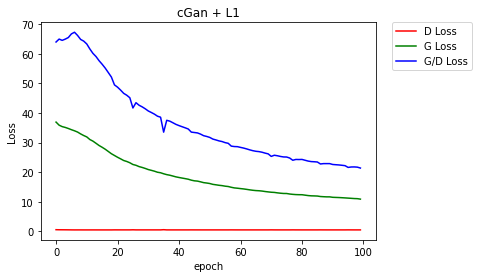

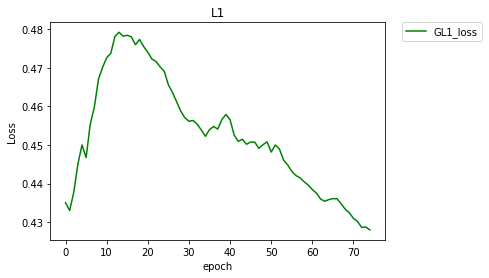

In [ ]:
# Plot the loss
##########--WRITE YOUR CODE HERE--##########
G_D_loss = []
for i in range(len(G_loss)):
  G_D_loss.append(G_loss[i]/D_loss[i])

plt.plot(D_loss , 'r', label= 'D Loss')
plt.plot(G_loss , 'g', label= 'G Loss')
plt.plot(G_D_loss , 'b', label= 'G/D Loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('cGan + L1')
plt.show()

plt.plot(GL1_loss , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('L1')

plt.show()
##########-------END OF CODE-------##########

### Part 5 Evaluation
---

Compared to a classification problem, evaluating an image translation model could be tricky because we don't always have the ground-truth available. There are several different ways to compare the performance of different GAN models:

1. Visualize the generated images of different GAN models. 

2. Compute a distance, such as **Frechet Inception Distance** (**FID**, the smaller the better, [paper](https://arxiv.org/abs/1706.08500)), between the generated images and the real images, or compute the Inception Score (**IS**, the higher the better, [paper](https://arxiv.org/pdf/1606.03498.pdf)) for the generated images. We strongly encourage you to read these papers.

3. Using generated images for downstream tasks, such as classification, segmentation, etc. and computing the task accuracy.

Now it's your turn to evaluate the models you trained. 

**{5 points}** We'll first visualize `4` test samples and plot them as in Figure 4 in the pix2pix paper, to get some qualitative results. You can select any interesting samples from the **test set**.

**{5 points}** Then let's do some quantitative analysis. Adapt this **Inception Score** ([ref](https://github.com/sbarratt/inception-score-pytorch/blob/master/inception_score.py)) implementation, and report the mean score of each model on the test set. Again, you are encouraged to train your models longer.

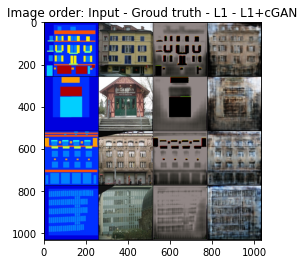

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

##########--WRITE YOUR CODE HERE--##########
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torchvision
test_loader = DataLoader(dataset("test"), 1, shuffle=True)
imgs = []
for j, (a, b) in enumerate(test_loader):
    a, b = a.to(device), b.to(device)
    with torch.no_grad():
        b_fake, b_fake_l1 = netG(a), netGL1(a)
    imgs += [a[0], b[0], b_fake_l1[0],b_fake[0]]
    if j == 3:
        break
imgs = torch.stack(imgs).detach().cpu()
save_image(imgs, "imgs.png", nrow=4, normalize=True)



import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.title('Image order: Input - Groud truth - L1 - L1+cGAN')
img = mpimg.imread('imgs.png')
imgplot = plt.imshow(img)

plt.show()

##########-------END OF CODE-------##########

In [38]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    N = len(images)
    batch_size = 1
    assert batch_size > 0
    assert N > batch_size

    # Seting up dataloader
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)

    def get_pred(x):
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # kl-div mean computation
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
from torch.autograd import Variable
test_pred = []
test_pred_l1 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(dataset("test"), 1, shuffle=True)
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        b_fake = netG(a)
        b_fake_l1 = netGL1(a)
    test_pred.append(b_fake)
    test_pred_l1.append(b_fake_l1)


##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1", f"{inception_s_l1:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

<ipython-input-38-55de4adcfaea>:22: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Loss,IS ↑
L1 + cGAN,2.1379
L1,3.7339


### Part 6 Understanding pix2pix
---
#### {5 points}Problem 1  
What image sizes can Pix2pix train with, and why can it handle different image sizes?

Hint: Explain this based on the generator and discriminator architectures.

#### {5 points}Problem 2 

Given an input image with size $256\times256\times6$ for the discriminator, write down the size of each neuron's receptive field after each layer, using the **discriminator** network architectures above:

e.g. $$Input → C64 → (?) → C128 →(?) → C256 → (?) → C512 → (?)$$

**Make sure you calculate the receptive field, not the size of the image.**

#### {5 points}Problem 3
Explain why minimizing only the L1 loss results in a blurry image. 


#### {5 points}Problem 4
Why do we use PatchGAN in Pix2pix? 


Answers: 
---

Problem 1:<br>
Answer: <br> Any sizes of images can be trained using Pix2pix. <br> 
Reason: The GAN used by Pix2pix is PatchGAN. As a result, the NxN input picture can vary based on its size. Instead of the entire input image, each output vector only displays the 70x70 patches or portions of the input image. The generator may also be applied to larger images than those it was trained on. As a result, it can handle photos of any size.
<br>

---

Problem 2:<br>
Answer: <br>

Layer Name = conv1, Output size = 128, Stride =   2, RF size =   4 <br>
Layer Name = conv2, Output size =  64, Stride =   4, RF size =  10 <br>
Layer Name = conv3, Output size =  32, Stride =   8, RF size =  22 <br>
Layer Name = conv4, Output size =  16, Stride =  16, RF size =  46 <br>

For obtaining the above results, we use <br>
Layer L's Receptive Field = Receptive Field for Layer L-1 * Stride + (Kernel Size - Stride)

---

Problem 3:<br>
Answer: <br>
The Euclidean distance between expected and actual pixels is used in L1 loss. The conditional probability density function's median is selected among all conceivable colors in order to minimize the Euclidean distance. In addition, L1 will tend to favor a blur when determining the precise placement of an edge. It will also encourage choosing one of the many potential color values for a pixel to have an average, grayish hue.

---

Problem 4:<br>
Answer: <br>
Pix2pix uses PatchGAN to produce outputs that are crisper and have higher FCN ratings. PatchGAN divides an image into real and fake 70 70 pixel patches in order to achieve high frequency accuracy. Similar to convolution, this patch sweeps across the image, averaging each 
<br>

---

### {10 points} Bonus: Spectral Normalization

Spectral normalization (**SN**, [paper](https://arxiv.org/abs/1802.05957)) is a simple and useful technique for stabilizing GAN training. Replace `batch normalization` with `spectral normalization` in both discriminator and generator, train the new model with the same L1 and cGAN loss for at least 20 epochs, then save the model to `pix2pixSN.pth`. Finally, perform the same evaluation you did in part 5 and compare the performance of all the models you trained.

Hint: use `torch.nn.utils.spectral_norm`.


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
# discriminator
class Discriminator(nn.Module):
    def __init__(self, n_channels):
        # n_channels means num of input channels
        super(Discriminator, self).__init__()
        ##########--WRITE YOUR CODE HERE--##########
        #C64−C128−C256−C512
        self.conv1 = nn.Conv2d(n_channels*2, 64, 4, 2, 1)
        self.conv2 = nn.Conv2d(64, 128, 4, 2, 1)
        self.conv3 = torch.nn.utils.spectral_norm(nn.Conv2d(128, 256, 4, 2, 1))
        self.conv4 = torch.nn.utils.spectral_norm(nn.Conv2d(256, 512, 4, 1, 1))
        self.conv5 = torch.nn.utils.spectral_norm(nn.Conv2d(512, 1, 4, 1, 1))
        ##########-------END OF CODE-------##########
        
    def forward(self, x):
        ##########--WRITE YOUR CODE HERE--##########
        x = torch.cat([x[0], x[1]], 1)
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu((self.conv2(x)), 0.2)
        x = F.leaky_relu((self.conv3(x)), 0.2)
        x = F.leaky_relu((self.conv4(x)), 0.2)
        x_d = F.sigmoid(self.conv5(x))        
        ##########-------END OF CODE-------##########
        return x_d

##########--WRITE YOUR CODE HERE--##########    
# netD = # initialize the discriminator
netD = Discriminator(3)
# feel free to do some sanity check here

##########-------END OF CODE-------##########    


In [ ]:
from torch.nn.utils import spectral_norm

class Convolution_block(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, activation=True, spectral_norm=True):
        super(Convolution_block, self).__init__()
        self.conv = torch.nn.Conv2d(input_size, output_size, kernel_size, stride, padding)
        self.activation = activation
        self.lrelu = torch.nn.LeakyReLU(0.2, True)
        self.spectral_norm = spectral_norm

    def forward(self, x):
        if self.activation:
            out = self.conv(self.lrelu(x))
        else:
            out = self.conv(x)
        return out
        
class DeConvolution_block(torch.nn.Module):
    def __init__(self, input_size, output_size, kernel_size=4, stride=2, padding=1, batch_norm=True, dropout=False):
        super(DeConvolution_block, self).__init__()
        self.deconv = torch.nn.ConvTranspose2d(input_size, output_size, kernel_size, stride, padding)
        self.drop = torch.nn.Dropout(0.5)
        self.relu = torch.nn.ReLU(True)
        self.spectral_norm = spectral_norm
        self.dropout = dropout

    def forward(self, x):
        out = self.deconv(self.relu(x))
        if self.dropout:
            return self.drop(out)
        else:
            return out
        
class Generator(torch.nn.Module):
    def __init__(self, input_dim):
        super(Generator, self).__init__()
        # Unet encoder: 𝐶64−𝐶128−𝐶256−𝐶512−𝐶512−𝐶512−𝐶512−𝐶512
        self.conv1 = Convolution_block(input_dim, 64, activation=False, spectral_norm=True)
        self.conv2 = Convolution_block(64, 128)
        self.conv3 = Convolution_block(128, 256)
        self.conv4 = Convolution_block(256, 512)
        self.conv5 = Convolution_block(512, 512)
        self.conv6 = Convolution_block(512, 512)
        self.conv7 = Convolution_block(512, 512)
        self.conv8 = Convolution_block(512, 512, spectral_norm=True)

        # Unet decoder : 𝐶𝐷512−𝐶𝐷1024−𝐶𝐷1024−𝐶1024−𝐶1024−𝐶512−𝐶256−𝐶128
        self.deconv1 = DeConvolution_block(512, 512, dropout=True)
        self.deconv2 = DeConvolution_block(1024, 512, dropout=True)
        self.deconv3 = DeConvolution_block(1024, 512, dropout=True)
        self.deconv4 = DeConvolution_block(1024, 512)
        self.deconv5 = DeConvolution_block(1024, 256)
        self.deconv6 = DeConvolution_block(512, 128)
        self.deconv7 = DeConvolution_block(256, 64)
        self.deconv8 = DeConvolution_block(128, 3)

    def forward(self, x):
        enc1 = self.conv1(x)
        enc2 = self.conv2(enc1)
        enc3 = self.conv3(enc2)
        enc4 = self.conv4(enc3)
        enc5 = self.conv5(enc4)
        enc6 = self.conv6(enc5)
        enc7 = self.conv7(enc6)
        enc8 = self.conv8(enc7)

        dec1 = self.deconv1(enc8)
        dec1 = torch.cat([dec1, enc7], 1)
        dec2 = self.deconv2(dec1)
        dec2 = torch.cat([dec2, enc6], 1)
        dec3 = self.deconv3(dec2)
        dec3 = torch.cat([dec3, enc5], 1)
        dec4 = self.deconv4(dec3)
        dec4 = torch.cat([dec4, enc4], 1)
        dec5 = self.deconv5(dec4)
        dec5 = torch.cat([dec5, enc3], 1)
        dec6 = self.deconv6(dec5)
        dec6 = torch.cat([dec6, enc2], 1)
        dec7 = self.deconv7(dec6)
        dec7 = torch.cat([dec7, enc1], 1)
        dec8 = self.deconv8(dec7)
        out = torch.nn.Tanh()(dec8)
        return out
    
netG = Generator(3)
netGL1 = Generator(3)

In [ ]:
# Define the optimizors here, make sure you give them the right parameters

##########--WRITE YOUR CODE HERE--########## 
optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_GL1 = optim.Adam(netGL1.parameters(), lr=0.0002, betas=(0.5, 0.999))

##########-------END OF CODE-------##########

In [ ]:
from torchvision.utils import save_image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

netG = netG.to(device)
netD = netD.to(device)
netG.train()
netD.train()

##########--WRITE YOUR CODE HERE--########## 

# loading images via data loader
from torch.utils.data import Dataset, DataLoader
import PIL
from PIL import Image

def load_image(file):
    img = PIL.Image.open(file)
    b_img = img.crop((0,0,256,256))
    a_img = img.crop((256,0,512,256))
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
    return transform(a_img), transform(b_img)

class dataset(Dataset):
    def __init__(self, mode):
        self.files = glob.glob('%s/%s/*'%('facades', mode))
    def __len__(self):
        return len(self.files)
    def __getitem__(self, idx):
        a, b = load_image(self.files[idx])
        return a, b

train_loader = DataLoader(dataset("train"), 1, shuffle=True)

def train_model(netG, netD, optim_G, optim_D, train_loader, epoch):

    G_loss, D_loss = [], []
    gan_loss = F.binary_cross_entropy_with_logits

    for i, (a, b) in enumerate(train_loader):

        a, b = a.to(device), b.to(device)
  
        real_image, fake_image = torch.ones((a.size(0), 1, 30, 30)).to(device) , torch.zeros((a.size(0), 1, 30, 30)).to(device)

        # Generator
        optim_G.zero_grad()
        fake_image_b = netG(a)
        pred = netD((a, fake_image_b))
        loss_G = gan_loss(pred, real_image) + F.l1_loss(b, fake_image_b) * 100

        # Backpropogation
        loss_G.backward()
        optim_G.step()

        # Discriminator

        optim_D.zero_grad()
        pred_real_image, pred_fake_image= netD((a, b)), netD((a, fake_image_b.detach()))
        loss_real_image, loss_fake_image = gan_loss(pred_real_image, real_image), gan_loss(pred_fake_image, fake_image)
        loss_D = (loss_real_image + loss_fake_image) * 0.5

        loss_D.backward()
        optim_D.step()

        G_loss.append(loss_G.item())
        D_loss.append(loss_D.item())

        if (i+1) % 10 == 0:
            g_mean, d_mean = np.mean(G_loss[-10:]), np.mean(D_loss[-10:])
            print(f"\rEpoch {epoch} [{i}/{len(train_loader)}] | G loss: {g_mean:.4f} | D loss: {d_mean:.4f}")

    return np.mean(G_loss), np.mean(D_loss)

#performing training
epochs = 20
G_losses = []
D_losses =[]
for epoch in range(epochs):
        G_loss, D_loss = train_model(netG, netD, optim_G, optim_D, train_loader, epoch)
        
        print(f'\nG Loss = {G_loss:.4f} | D Loss = {D_loss:.4f} | G/D Loss = {G_loss/D_loss:.4f}\n')
        G_losses.append(G_loss)
        D_losses.append(D_loss)
##########-------END OF CODE-------##########

/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 0 [9/400] | G loss: 49.8350 | D loss: 0.6954
Epoch 0 [19/400] | G loss: 40.4205 | D loss: 0.6614
Epoch 0 [29/400] | G loss: 43.2525 | D loss: 0.6597
Epoch 0 [39/400] | G loss: 37.8438 | D loss: 0.6333
Epoch 0 [49/400] | G loss: 41.3261 | D loss: 0.6345
Epoch 0 [59/400] | G loss: 40.0274 | D loss: 0.6763
Epoch 0 [69/400] | G loss: 37.6910 | D loss: 0.6513
Epoch 0 [79/400] | G loss: 37.8081 | D loss: 0.6074
Epoch 0 [89/400] | G loss: 45.0296 | D loss: 0.5668
Epoch 0 [99/400] | G loss: 37.1045 | D loss: 0.5508
Epoch 0 [109/400] | G loss: 37.7790 | D loss: 0.5456
Epoch 0 [119/400] | G loss: 35.8520 | D loss: 0.5704
Epoch 0 [129/400] | G loss: 38.2411 | D loss: 0.5765
Epoch 0 [139/400] | G loss: 39.8113 | D loss: 0.5930
Epoch 0 [149/400] | G loss: 37.0351 | D loss: 0.5506
Epoch 0 [159/400] | G loss: 38.2138 | D loss: 0.5852
Epoch 0 [169/400] | G loss: 39.8981 | D loss: 0.5532
Epoch 0 [179/400] | G loss: 42.9552 | D loss: 0.5685
Epoch 0 [189/400] | G loss: 39.1108 | D loss: 0.5489
Epoc

In [ ]:
netGL1 = netGL1.to(device)
netGL1.train()

##########--WRITE YOUR CODE HERE--########## 
def train_model(netGL1, optim_G, train_loader, epoch):

    GL1_loss = []

    for i, (a, b) in enumerate(train_loader):
        a, b = a.to(device), b.to(device)
        real , fake= torch.ones((a.size(0), 1, 30, 30)).to(device), torch.zeros((a.size(0), 1, 30, 30)).to(device)
        optim_G.zero_grad()
        b_fake = netGL1(a)
        loss_G = F.l1_loss(b, b_fake)
        loss_G.backward()
        optim_GL1.step()
        GL1_loss.append(loss_G.item())

        if (i+1) % 10 == 0:
            g_mean = np.mean(GL1_loss[-10:])
            print(f"\rEpoch {epoch} [{i}/{len(train_loader)}] | GL1 loss: {g_mean:.4f}")

        iters = epoch * len(train_loader) + i

    return np.mean(GL1_loss)

epoch_l1 = 20
GL1_losses = []
for epoch in range(epoch_l1):
        GL1_loss = train_model(netGL1, optim_G, train_loader, epoch)
        print(f'\nGL1_loss: {GL1_loss:.4f} \n')
        GL1_losses.append(GL1_loss)
##########-------END OF CODE-------##########

Epoch 0 [9/400] | GL1 loss: 0.4225
Epoch 0 [19/400] | GL1 loss: 0.3962
Epoch 0 [29/400] | GL1 loss: 0.4010
Epoch 0 [39/400] | GL1 loss: 0.4222
Epoch 0 [49/400] | GL1 loss: 0.3822
Epoch 0 [59/400] | GL1 loss: 0.4029
Epoch 0 [69/400] | GL1 loss: 0.3910
Epoch 0 [79/400] | GL1 loss: 0.4606
Epoch 0 [89/400] | GL1 loss: 0.4173
Epoch 0 [99/400] | GL1 loss: 0.3713
Epoch 0 [109/400] | GL1 loss: 0.3698
Epoch 0 [119/400] | GL1 loss: 0.3873
Epoch 0 [129/400] | GL1 loss: 0.3885
Epoch 0 [139/400] | GL1 loss: 0.4334
Epoch 0 [149/400] | GL1 loss: 0.3915
Epoch 0 [159/400] | GL1 loss: 0.3893
Epoch 0 [169/400] | GL1 loss: 0.3869
Epoch 0 [179/400] | GL1 loss: 0.3783
Epoch 0 [189/400] | GL1 loss: 0.3788
Epoch 0 [199/400] | GL1 loss: 0.4117
Epoch 0 [209/400] | GL1 loss: 0.3904
Epoch 0 [219/400] | GL1 loss: 0.3892
Epoch 0 [229/400] | GL1 loss: 0.3618
Epoch 0 [239/400] | GL1 loss: 0.4254
Epoch 0 [249/400] | GL1 loss: 0.4011
Epoch 0 [259/400] | GL1 loss: 0.3613
Epoch 0 [269/400] | GL1 loss: 0.3907
Epoch 0 [279

In [ ]:
# codes for saving models, feel free to change them

torch.save({
    'G': netG.state_dict(),
    'D': netD.state_dict(),
    'epoch': epochs,
    'loss_G': G_losses,
    'loss_D': D_losses,
    }, 'pix2pix_spectral.pth')

torch.save({
    'G': netGL1.state_dict(),
    'epoch': epoch_l1,
    'loss': GL1_losses,
    }, 'pix2pixL1_spectral.pth')


In [ ]:
# codes for restoring models, feel free to change them

path = "pix2pix_spectral.pth"
checkpoint = torch.load(path)
netG.load_state_dict(checkpoint['G'])
netD.load_state_dict(checkpoint['D'])
epoch = checkpoint['epoch']
G_loss = checkpoint['loss_G']
D_loss = checkpoint['loss_D']

path = "pix2pixL1_spectral.pth"
checkpoint = torch.load(path)
netGL1.load_state_dict(checkpoint['G'])
epoch_l1 = checkpoint['epoch']
GL1_loss = checkpoint['loss']

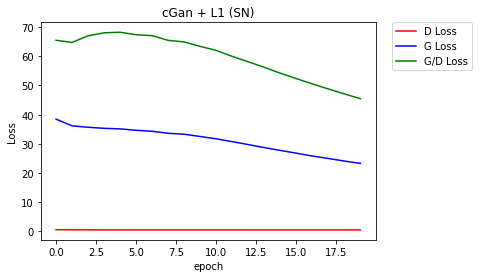

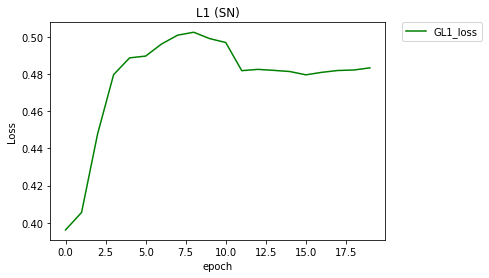

In [ ]:
# Plot the loss
##########--WRITE YOUR CODE HERE--##########
G_D_loss = []
for i in range(len(G_loss)):
  G_D_loss.append(G_loss[i]/D_loss[i])

plt.plot(D_loss , 'r', label= 'D Loss')
plt.plot(G_loss , 'b', label= 'G Loss')
plt.plot(G_D_loss , 'g', label= 'G/D Loss')

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('cGan + L1 (SN)')
plt.show()

plt.plot(GL1_loss , 'g', label= 'GL1_loss')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.title('L1 (SN)')

plt.show()
##########-------END OF CODE-------##########

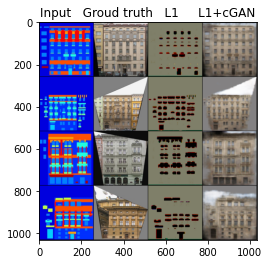

In [ ]:
# Visualization
# Please read Figure 4 in the pix2pix paper first

##########--WRITE YOUR CODE HERE--##########
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_loader = DataLoader(dataset("test"), 1, shuffle=True)
imgs = []
for j, (a, b) in enumerate(test_loader):
    a, b = a.to(device), b.to(device)
    with torch.no_grad():
        b_fake, b_fake_l1 = netG(a), netGL1(a)
    imgs += [a[0], b[0], b_fake_l1[0],b_fake[0]]
    if j == 3:
        break
imgs = torch.stack(imgs).detach().cpu()
save_image(imgs, "imgs.png", nrow=4, normalize=True)

plt.title('Input   Groud truth   L1     L1+cGAN')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('imgs.png')
imgplot = plt.imshow(img)

plt.show()

##########-------END OF CODE-------##########

In [37]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    N = len(images)
    #print(N)
    batch_size = 1
    assert batch_size > 0
    assert N > batch_size

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)

    def get_pred(x):
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
from torch.autograd import Variable
test_pred = []
test_pred_l1 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(dataset("test"), 1, shuffle=True)
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        b_fake = netG(a)
        b_fake_l1 = netGL1(a)
    test_pred.append(b_fake)
    test_pred_l1.append(b_fake_l1)

##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1", f"{inception_s_l1:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

<ipython-input-37-22649f16e540>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Loss,IS ↑
L1 + cGAN,2.1972
L1,3.7622


In [ ]:
# Inception Scores
from torchvision.models.inception import inception_v3
from scipy.stats import entropy

dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
inception_model.eval();
up = nn.Upsample(size=(299, 299), mode='bilinear', align_corners=True).type(dtype)

def inception_score(images, splits=10):
    ##########--WRITE YOUR CODE HERE--##########
    N = len(images)
    #print(N)
    batch_size = 1
    assert batch_size > 0
    assert N > batch_size

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(images, batch_size=batch_size)

    def get_pred(x):
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch[0].type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    ##########-------END OF CODE-------##########
    return np.mean(split_scores)


# Get the translation on test set
##########--WRITE YOUR CODE HERE--##########
from torch.autograd import Variable
test_pred = []
test_pred_l1 = []
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_loader = DataLoader(dataset("test"), 1, shuffle=True)
for j, (a, b) in enumerate(test_loader):
    a = a.to(device)
    b = b.to(device)
    with torch.no_grad():
        b_fake = netG(a)
        b_fake_l1 = netGL1(a)
    test_pred.append(b_fake)
    test_pred_l1.append(b_fake_l1)

##########-------END OF CODE-------##########

inception_s = inception_score(test_pred)
inception_s_l1 = inception_score(test_pred_l1)
from IPython.display import HTML, display
import tabulate
table = [["Loss","IS ↑"],
         ["L1 + cGAN", f"{inception_s:.4f}"],
         ["L1", f"{inception_s_l1:.4f}"]]
display(HTML(tabulate.tabulate(table, tablefmt='html', headers="firstrow")))

<ipython-input-37-22649f16e540>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


Loss,IS ↑
L1 + cGAN,2.1972
L1,3.7622


## Submission guidelines
---
We will grade your homework based on your submitted notebook file. We will check the notebook for both results and code. Please make sure you run your code and print out the results in the notebook before submitting (we expect to see the results before running your code by ourselves.)

You submit your homework by first creating a ***google shared link*** of a folder for your homework (described below), and put that link into the ***text submission section*** of your homework submission on Blackboard. ([How to submit your link?](https://drive.google.com/file/d/16-FlPSiu5n-pRezLfcbAvgYxXtGtrs16))

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your CS account (or your SBU account if you don't have a CS account). The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw5
        |---CSE527-22F-HW5.ipynb
```
Note that this folder should be in your Google Drive with your account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TAs' email: ***haoyuwu@cs.stonybrook.edu*** and ***vhnguyen@cs.stonybrook.edu***. Make sure that the TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box. ([How to share link?](https://drive.google.com/file/d/17R6j6yE8_8vXioOB3nNvbEPzxcI-rr_H) )

***IMPORTANT: Please do not make any modification to the folder and its files after the submission deadline***. (All modifications can be seen by the TAs via the revision history.) Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard.

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.
